# Trying a new Training Notebook

Inspired by https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

In [62]:
import keras.backend as K
import keras
import numpy as np
import os
from scipy.misc import imread
from keras.layers import Flatten, Dense
from keras import regularizers
from keras.models import Model
from DataGenerator import DataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf


data_dir = 'mini-train'
val_pct = 0.2
batch_size = 32

mean = np.load('mean_mini_train.npy')
std = np.sqrt(np.load('std_mini_train.npy'))

In [2]:
class_dirs = os.listdir(data_dir)
image_list = []
labels = {}
cur_label = 0
class_to_labels = {}
num_classes = 0
for class_dir in class_dirs:
    num_classes += 1
    class_dir_path = os.path.join(data_dir, class_dir)
    imgs = os.listdir(class_dir_path)
    for img in imgs:
        img_id = os.path.join(data_dir, class_dir, img)
        image_list.append(img_id)
        if class_dir in class_to_labels:
            labels[img_id] = class_to_labels[class_dir]
        else:
            class_to_labels[class_dir] = cur_label
            labels[img_id] = cur_label
            cur_label += 1

num_images = len(image_list)        
np.random.shuffle(image_list)

partition = {'train':image_list[int(num_images*val_pct):], 'val':image_list[:int(num_images*val_pct)]}

Set up some callbacks.

In [20]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=0, mode='auto')
tfboard = TensorBoard(batch_size=batch_size)
checkpoint = ModelCheckpoint("checkpoints/{epoch:02d}-{val_acc:.2f}.hdf5", 
                             monitor='val_acc',
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

callbacks = [early, tfboard, checkpoint]

In [4]:
def declare_model(reg=0):
    resnet = keras.applications.resnet50.ResNet50(include_top=False,
     weights="imagenet",
     input_shape=(224,224,3),
     pooling=None)
    # We will train the last 5 layers of ResNET and leave the others unchanged
    for layer in resnet.layers[:-5]:
        layer.trainable = False

    x = resnet.output
    x = Flatten()(x)
    x = Dense(2*num_classes, activation='relu', kernel_regularizer=regularizers.l2(reg))(x)
    scores = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(reg))(x)

    return Model(inputs=resnet.inputs, outputs=scores)

In [51]:
def gap(y_true, y_pred):
    # I actually cannot believe tensorflow is this popular.
    inds = tf.to_int32(K.argmax(y_true, axis=1))
    inds2 = tf.expand_dims(inds, 1)
    range = tf.expand_dims(tf.range(tf.shape(inds)[0]), 1)
    inds = tf.concat([range, inds2], 1)
    selected = tf.gather_nd(y_pred, inds)
    # 5 LINES FOR SOME SIMPLE INDEXING!??!?!?
    sm =  K.sum(selected)
    denom = K.shape(y_true)[0]
    denom = tf.to_float(denom)
    return sm/denom

In [52]:
K.clear_session()
model = declare_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', gap])

In [63]:
training_generator = DataGenerator(partition['train'], labels, n_classes=num_classes)
validation_generator = DataGenerator(partition['val'], labels, n_classes=num_classes)

hist = model.fit_generator(generator=training_generator,
                           validation_data=validation_generator,
                           use_multiprocessing=True,
                           workers=6,
                           callbacks=callbacks)

model.save('models/train0_model.h5')

Epoch 1/1


  1/346 [..............................] - ETA: 1:29:23 - loss: 7.2220 - acc: 0.0312 - gap: 9.2647e-04

  2/346 [..............................] - ETA: 1:14:26 - loss: 7.1420 - acc: 0.0312 - gap: 0.0011    

  3/346 [..............................] - ETA: 1:09:33 - loss: 7.1095 - acc: 0.0208 - gap: 0.0010

  4/346 [..............................] - ETA: 1:07:26 - loss: 7.1155 - acc: 0.0234 - gap: 0.0010

  5/346 [..............................] - ETA: 1:06:35 - loss: 7.1475 - acc: 0.0187 - gap: 0.0010

  6/346 [..............................] - ETA: 1:05:06 - loss: 7.1363 - acc: 0.0156 - gap: 0.0010

  7/346 [..............................] - ETA: 1:04:40 - loss: 7.0840 - acc: 0.0268 - gap: 0.0013

  8/346 [..............................] - ETA: 1:09:08 - loss: 7.0484 - acc: 0.0234 - gap: 0.0014

  9/346 [..............................] - ETA: 1:10:50 - loss: 7.0268 - acc: 0.0243 - gap: 0.0014

 10/346 [..............................] - ETA: 1:10:05 - loss: 7.0110 - acc: 0.0281 - gap: 0.0014

 11/346 [..............................] - ETA: 1:09:04 - loss: 7.0156 - acc: 0.0312 - gap: 0.0015

 12/346 [>.............................] - ETA: 1:07:54 - loss: 7.0099 - acc: 0.0312 - gap: 0.0015

 13/346 [>.............................] - ETA: 1:06:37 - loss: 6.9990 - acc: 0.0337 - gap: 0.0015

 14/346 [>.............................] - ETA: 1:05:23 - loss: 7.0162 - acc: 0.0312 - gap: 0.0015

 15/346 [>.............................] - ETA: 1:04:20 - loss: 7.0284 - acc: 0.0354 - gap: 0.0016

 16/346 [>.............................] - ETA: 1:03:20 - loss: 7.0247 - acc: 0.0332 - gap: 0.0016

 17/346 [>.............................] - ETA: 1:02:36 - loss: 7.0223 - acc: 0.0349 - gap: 0.0017

Process ForkPoolWorker-106:


Process ForkPoolWorker-108:


Process ForkPoolWorker-107:


Process ForkPoolWorker-105:


Process ForkPoolWorker-104:


Process ForkPoolWorker-103:


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt


KeyboardInterrupt


KeyboardInterrupt


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)


KeyboardInterrupt


  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


KeyboardInterrupt


Epoch 1/1


KeyboardInterrupt: 

In [33]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


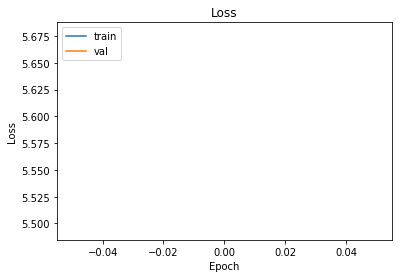

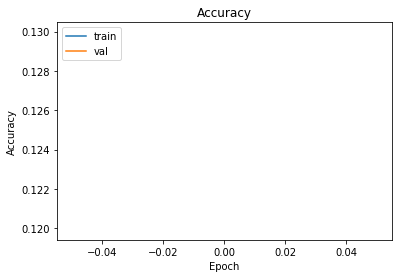

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()